# Preparing the dataset for hippocampus segmentation

In this notebook you will use the skills and methods that we have talked about during our EDA Lesson to prepare the hippocampus dataset using Python. Follow the Notebook, writing snippets of code where directed so using Task comments, similar to the one below, which expects you to put the proper imports in place. Write your code directly in the cell with TASK comment. Feel free to add cells as you see fit, but please make sure that code that performs that tasked activity sits in the same cell as the Task comment.


In [12]:
# TASK: Import the following libraries that we will use: nibabel, matplotlib, numpy
import pydicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nibabel as nib
import numpy.ma as ma
import numpy as np
import os

It will help your understanding of the data a lot if you were able to use a tool that allows you to view NIFTI volumes, like [3D Slicer](https://www.slicer.org/). I will refer to Slicer throughout this Notebook and will be pasting some images showing what your output might look like.

## Loading NIFTI images using NiBabel

NiBabel is a python library for working with neuro-imaging formats (including NIFTI) that we have used in some of the exercises throughout the course. Our volumes and labels are in NIFTI format, so we will use nibabel to load and inspect them.

NiBabel documentation could be found here: https://nipy.org/nibabel/

Our dataset sits in two directories - *images* and *labels*. Each image is represented by a single file (we are fortunate to have our data converted to NIFTI) and has a corresponding label file which is named the same as the image file.

Note that our dataset is "dirty". There are a few images and labels that are not quite right. They should be quite obvious to notice, though. The dataset contains an equal amount of "correct" volumes and corresponding labels, and you don't need to alter values of any samples in order to get the clean dataset.

In [33]:
# TASK: Your data sits in directory /data/TrainingSet.
# Load an image and a segmentation mask into variables called image and label

# specify the data directory
data_dir = "../data/TrainingSet"
image_dir = os.path.join(data_dir, "images")
label_dir = os.path.join(data_dir, "labels")

# select an image and segmentation mask from the directory
image = os.listdir(image_dir)[0]  # select the 42th image in the directory
label = os.listdir(label_dir)[0]   # select the 42th label in the directory
print(image, label)

hippocampus_367.nii.gz hippocampus_367.nii.gz


Image dimensions: (36, 57, 37)
Label dimensions: (36, 57, 37)
Selected Slice:  [18, 28, 18]


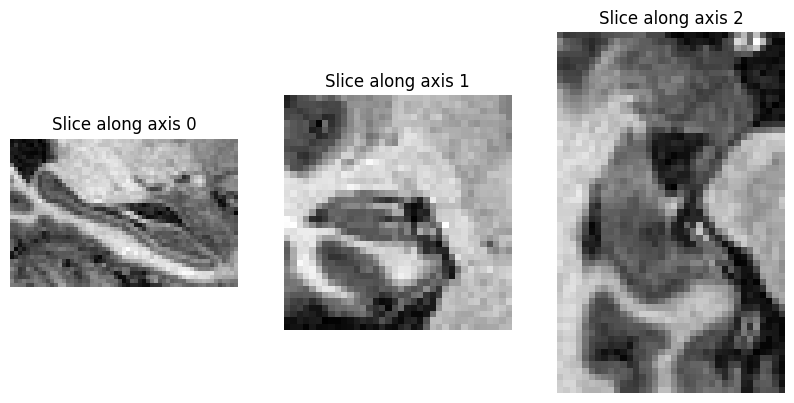

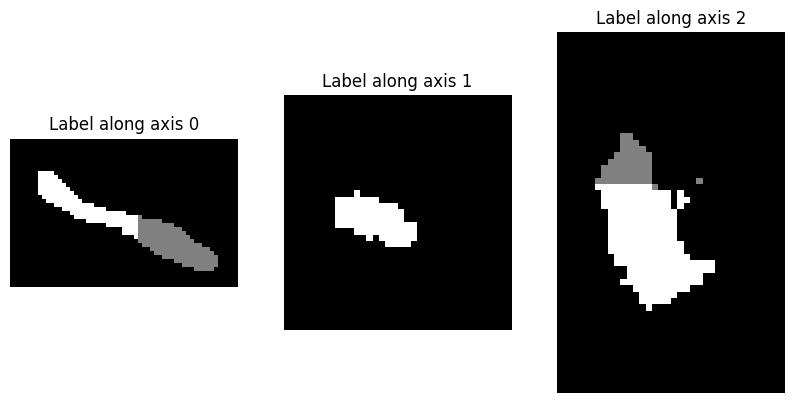

In [34]:
# Nibabel can present your image data as a Numpy array by calling the method get_fdata()
# The array will contain a multi-dimensional Numpy array with numerical values representing voxel intensities. 
# In our case, images and labels are 3-dimensional, so get_fdata will return a 3-dimensional array. You can verify this
# by accessing the .shape attribute. What are the dimensions of the input arrays?

# Load an image
image_path = os.path.join(image_dir, image)
image_nib = nib.load(image_path)
image_data = image_nib.get_fdata()

# Load a segmentation mask
label_path = os.path.join(label_dir, label)
label_nib = nib.load(label_path)
label_data = label_nib.get_fdata()

# Print the dimensions of the input arrays
print("Image dimensions:", image_data.shape)
print("Label dimensions:", label_data.shape)

# TASK: using matplotlib, visualize a few slices from the dataset, along with their labels. 
# You can adjust plot sizes like so if you find them too small:
# plt.rcParams["figure.figsize"] = (10,10)

plt.rcParams["figure.figsize"] = (10,10)

def show_slices(slices, titles):
    """Function to display a row of image slices"""
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        axes[i].set_title(titles[i])
        axes[i].axis("off")

# Visualize the middle slices from each axis
slice_idx = [image_data.shape[i] // 2 for i in range(3)]
print("Selected Slice: ", slice_idx)
show_slices([image_data[slice_idx[0], :, :], image_data[:, slice_idx[1], :], image_data[:, :, slice_idx[2]]],
            ["Slice along axis 0", "Slice along axis 1", "Slice along axis 2"])
show_slices([label_data[slice_idx[0], :, :], label_data[:, slice_idx[1], :], label_data[:, :, slice_idx[2]]],
            ["Label along axis 0", "Label along axis 1", "Label along axis 2"])


Load volume into 3D Slicer to validate that your visualization is correct and get a feel for the shape of structures.Try to get a visualization like the one below (hint: while Slicer documentation is not particularly great, there are plenty of YouTube videos available! Just look it up on YouTube if you are not sure how to do something)

![3D slicer](img/Slicer.png)

In [ ]:
# Stand out suggestion: use one of the simple Volume Rendering algorithms that we've
# implemented in one of our earlier lessons to visualize some of these volumes

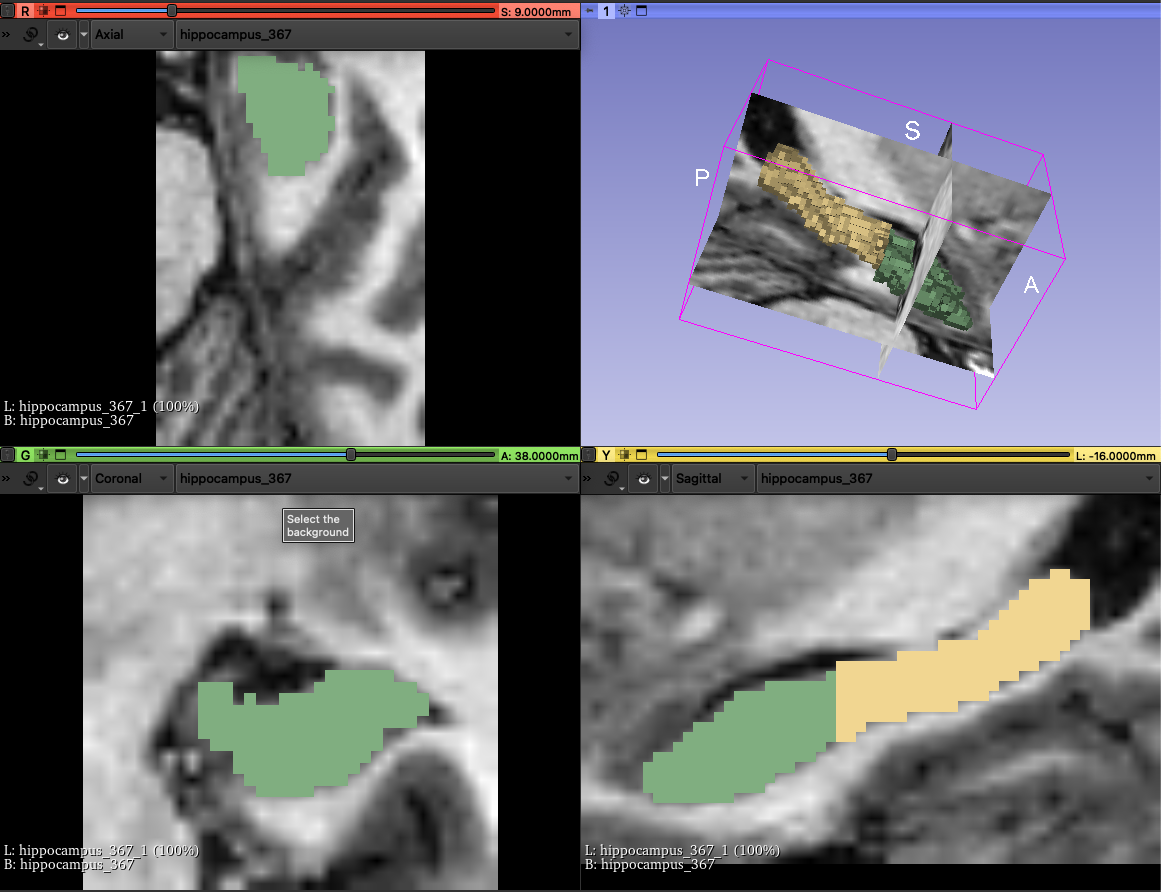

## Looking at single image data
In this section we will look closer at the NIFTI representation of our volumes. In order to measure the physical volume of hippocampi, we need to understand the relationship between the sizes of our voxels and the physical world.

In [36]:
# Nibabel supports many imaging formats, NIFTI being just one of them. I told you that our images 
# are in NIFTI, but you should confirm if this is indeed the format that we are dealing with
# TASK: using .header_class attribute - what is the format of our images?

# Check the format of the image
print("Image format:", image_nib.header_class)

Image format: <class 'nibabel.nifti1.Nifti1Header'>


Further down we will be inspecting .header attribute that provides access to NIFTI metadata. You can use this resource as a reference for various fields: https://brainder.org/2012/09/23/the-nifti-file-format/

In [37]:
# TASK: How many bits per pixel are used?
# Get the number of bits per pixel
bits_per_pixel = image_nib.header['bitpix']
print("Bits per pixel:", bits_per_pixel)

Bits per pixel: 32


In [38]:
# TASK: What are the units of measurement?
# Get the units of measurement
xyzt_units = image_nib.header.get_xyzt_units()

# Display the units of measurement
spatial_units, temporal_units = xyzt_units
print("Spatial units:", spatial_units)
print("Temporal units:", temporal_units)

Spatial units: mm
Temporal units: sec


In [39]:
# TASK: Do we have a regular grid? What are grid spacings?
# Get the grid spacings
grid_spacings = image_nib.header['pixdim'][1:4]

# Display the grid spacings
print("Grid spacings (x, y, z):", grid_spacings)

# Check if the grid is regular
is_regular_grid = (grid_spacings[0] == grid_spacings[1] == grid_spacings[2])
print("Regular grid:", is_regular_grid)

Grid spacings (x, y, z): [1. 1. 1.]
Regular grid: True


In [41]:
# TASK: What dimensions represent axial, sagittal, and coronal slices? How do you know?
# Get the affine matrix
affine = image_nib.affine

# Display the affine matrix
print("Affine matrix:")
print(affine)

# Interpret the affine matrix to determine the mapping of anatomical planes to image dimensions
print("Mapping of anatomical planes to image dimensions:")
if abs(affine[0, 0]) > abs(affine[0, 1]) and abs(affine[0, 0]) > abs(affine[0, 2]):
    print("x-axis: sagittal")
elif abs(affine[1, 1]) > abs(affine[1, 0]) and abs(affine[1, 1]) > abs(affine[1, 2]):
    print("y-axis: coronal")
elif abs(affine[2, 2]) > abs(affine[2, 0]) and abs(affine[2, 2]) > abs(affine[2, 1]):
    print("z-axis: axial")

Affine matrix:
[[1. 0. 0. 1.]
 [0. 1. 0. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]]
Mapping of anatomical planes to image dimensions:
x-axis: sagittal


In [43]:
# By now you should have enough information to decide what are dimensions of a single voxel
# TASK: Compute the volume (in mm³) of a hippocampus using one of the labels you've loaded. 
# You should get a number between ~2200 and ~4500

# Compute the volume of a single voxel
voxel_volume = np.prod(grid_spacings)

# Compute the volume of the hippocampus
hippocampus_volume = np.sum(label_data > 0) * voxel_volume

print(f"Hippocampus volume: {hippocampus_volume} mm³")


Hippocampus volume: 4151.0 mm³


## Plotting some charts

outlier:  ../data/TrainingSet/labels/hippocampus_281.nii.gz
['../data/TrainingSet/labels/hippocampus_281.nii.gz']


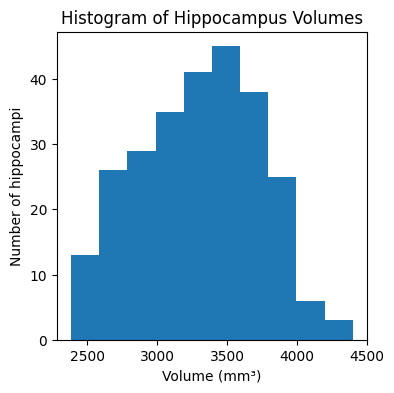

In [71]:
# TASK: Plot a histogram of all volumes that we have in our dataset and see how 
# our dataset measures against a slice of a normal population represented by the chart below.

# specify the data directory
data_dir = "../data/TrainingSet"
label_dir = os.path.join(data_dir, "labels")

# initialize a list to store the hippocampus volumes
hippocampus_volumes = []
outlier_labels = []

# iterate over the labels in the directory
for label_name in os.listdir(label_dir):
    # Load a label
    label_path = os.path.join(label_dir, label_name)
    label_nib = nib.load(label_path)

    # Get the voxel data
    label_data = label_nib.get_fdata()

    # Get the grid spacings
    grid_spacings = label_nib.header['pixdim'][1:4]

    # Compute the volume of a single voxel
    voxel_volume = np.prod(grid_spacings)

    # Compute the volume of the hippocampus and add it to the list
    hippocampus_volume = np.sum(label_data > 0) * voxel_volume
    hippocampus_volumes.append(hippocampus_volume)
    if hippocampus_volume > 10000:
        print("outlier: ", label_path)
        outlier_labels.append(label_path)

hippocampus_volumes = [ h for h in hippocampus_volumes if h <= 10000] # remove outlier 
# Plot a histogram of the hippocampus volumes
plt.rcParams["figure.figsize"] = (4,4)
plt.hist(hippocampus_volumes, bins=10)
plt.xlabel("Volume (mm³)")
plt.ylabel("Number of hippocampi")
plt.title("Histogram of Hippocampus Volumes")
plt.show()

<img src="img/nomogram_fem_right.svg" width=400 align=left>

Do you see any outliers? Why do you think it's so (might be not immediately obvious, but it's always a good idea to inspect) outliers closer. If you haven't found the images that do not belong, the histogram may help you.

In the real world we would have precise information about the ages and conditions of our patients, and understanding how our dataset measures against population norm would be the integral part of clinical validation that we talked about in last lesson. Unfortunately, we do not have this information about this dataset, so we can only guess why it measures the way it is. If you would like to explore further, you can use the [calculator from HippoFit project](http://www.smanohar.com/biobank/calculator.html) to see how our dataset compares against different population slices

Did you notice anything odd about the label files? We hope you did! The mask seems to have two classes, labeled with values `1` and `2` respectively. If you visualized sagittal or axial views, you might have gotten a good guess of what those are. Class 1 is the anterior segment of the hippocampus and class 2 is the posterior one. 

For the purpose of volume calculation we do not care about the distinction, however we will still train our network to differentiate between these two classes and the background

In [72]:
# TASK: Copy the clean dataset to the output folder inside section1/out. You will use it in the next Section
import shutil
# specify the input and output directories
data_dir = "../data/TrainingSet"
output_dir = "../section1/out"
image_dir = os.path.join(data_dir, "images")
label_dir = os.path.join(data_dir, "labels")
output_image_dir = os.path.join(output_dir, "images")
output_label_dir = os.path.join(output_dir, "labels")

# create the output directories if they don't exist
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

# Copy the images and labels without outliers to the output directory
for image_name in os.listdir(image_dir):
    # Skip the image if the corresponding label is an outlier
    if image_name in outlier_labels or ".DS_Store":
        continue

    # Copy the image
    shutil.copy(os.path.join(image_dir, image_name), os.path.join(output_image_dir, image_name))

    # Copy the corresponding label
    shutil.copy(os.path.join(label_dir, image_name), os.path.join(output_label_dir, image_name))


## Final remarks

Congratulations! You have finished Section 1. 

In this section you have inspected a dataset of MRI scans and related segmentations, represented as NIFTI files. We have visualized some slices, and understood the layout of the data. We have inspected file headers to understand what how the image dimensions relate to the physical world and we have understood how to measure our volume. We have then inspected dataset for outliers, and have created a clean set that is ready for consumption by our ML algorithm. 

In the next section you will create training and testing pipelines for a UNet-based machine learning model, run and monitor the execution, and will produce test metrics. This will arm you with all you need to use the model in the clinical context and reason about its performance!